In [5]:
!pip install numpyro

In [6]:
pip install pymc==5.9.0

In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import os, sys, warnings, pytz
from datetime import datetime
warnings.filterwarnings("ignore")
timezone = pytz.timezone('America/Chicago')
from matplotlib import pyplot as plt
from scipy.stats import norm, dirichlet, invgamma, truncnorm, beta, gamma
from sklearn.model_selection import train_test_split
from scipy.stats import probplot

import arviz as az
import pymc as pm
import pymc.sampling.jax as pmjax
import graphviz

In [8]:
#read in the raw data and immediately remove non balls in play to save memory. Only go back to 2020 to save time when training models
from google.colab import drive
drive.mount('/drive')

raw22= pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw22.csv')
raw22 = raw22.loc[raw22['type'] == 'X']

raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw21.csv')
raw21 = raw21.loc[raw21['type'] == 'X']

raw20 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw20.csv')
raw20 = raw20.loc[raw20['type'] == 'X']

raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/raw19.csv')
raw19 = raw19.loc[raw19['type'] == 'X']

Mounted at /drive


In [9]:
#combine
all_data = pd.concat((raw22, raw21))#, raw20, raw19))

del raw22
del raw21
del raw20
del raw19

#we only want balls in play with non-null measurements
all_data = all_data.loc[all_data['type'] == 'X']
all_data = all_data.dropna(subset = ['hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'hit_distance_sc'])

#one hot encode handedness
pit_hand = pd.get_dummies(all_data['p_throws'], drop_first = False)
bat_hand = pd.get_dummies(all_data['stand'], drop_first = False)
all_data['pit_handR'] = pit_hand['R']
all_data['bat_handR'] = bat_hand['R']

#hit direction
all_data['x'] = all_data.hc_x.values - 125.42
all_data['y'] = 198.27 - all_data.hc_y.values
all_data['hit_direction'] = np.arctan2(all_data.x.values, all_data.y.values) * 180/np.pi
#scale hit direction by -1 for lefties so we can consider all hitters at the same time
all_data.loc[all_data.bat_handR == 0, 'hit_direction'] *= -1

#remove extreme angles. It seems intuitive to remove angles greater than 45 degrees for the foul line.
#However, I only have balls in play in my dataset, and yet there are a lot of balls with angles greater than 45 degrees.
#I don't know if that is bad measurements or an effect of the wind or what, but if I cut off the angles too soon, when I go
#to fit the beta dists, I get really steep lines at 0 and 1, like undefined slopes almost, which messes up the advi optimizer,
#so it works better if I cut it off at 55 and then when I go to sample batted balls to optimize for positioning, I will remove batted
#balls from the sample that land at an angle greater than 45 because those are foul.
all_data = all_data.loc[np.abs(all_data.hit_direction) < 55]

#shift and scale so that hit directions are between 0 and 1
all_data['hd'] = (all_data.hit_direction.values + 55) / 110

#batterid/hand
all_data['batter_id_hand'] = all_data.batter.astype(str) + '-' + all_data.bat_handR.astype(str)

#keep only the necessary columns
all_data = all_data[['pitch_type', 'game_date', 'batter', 'batter_id_hand', 'home_team', 'away_team',
                     'balls', 'strikes', 'game_year', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up',
                     'inning', 'launch_speed', 'launch_angle', 'if_fielding_alignment', 'of_fielding_alignment', 'pit_handR',
                     'bat_handR', 'x', 'y', 'hit_direction', 'hd']]

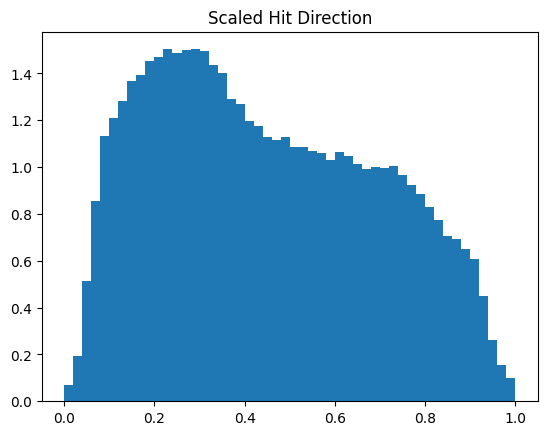

In [10]:
plt.hist(all_data.hd.values, density = True, bins = 50)
plt.title('Scaled Hit Direction')
plt.show()

In [11]:
#we're comparing how hitters do against the shift versus non shift, so remove positioning alignments that aren't shift or standard
all_data = all_data.loc[(all_data.if_fielding_alignment == 'Standard') | (all_data.if_fielding_alignment == 'Infield shift')]
all_data['is_shift'] = 0
all_data.loc[all_data.if_fielding_alignment == 'Infield shift', 'is_shift'] = 1

In [12]:
#redefine as train so that I can copy and paste
train = all_data.copy()

#batter indices: we need indices for the batter and handedness so that we handle switch hitters appropriately
batter_indices = pd.DataFrame({'batter_id_hand':np.sort(train.batter_id_hand.unique())})

batter_indices['batter_index'] = batter_indices.index.values

train = train.merge(batter_indices, on = 'batter_id_hand')

### **Model:** Mixture of Betas

In [ ]:
#for the prior for the weights, I'm just going to go with dirichlet([0.4,0.6]), so just use the exact probabilities I found in the exploratory notebook.
#for the priors for the alpha and beta parameters in the beta distributions, I want them to have mean of [3,3] for alpha and [9,2] for beta based on
#what I found in the exploratory notebook, but I don't know what to do with variance. So I am just going to try to match the variance I had in the
#hit direction 1 notebook, which was about 0.024 and 0.027 for alpha and beta repsectively. I'll go a little bit bigger than that to be safe, 0.03 and 0.03
weight_prior_alpha = np.array([0.4, 0.6])
alpha_prior_mean = np.array([3,3])
alpha_prior_var = np.array([0.03,0.03])
beta_prior_mean = np.array([9,2])
beta_prior_var = np.array([0.03,0.03])

In [ ]:
n_batters = len(train.batter_index.unique())
nclusters = 2
coords = {'batter': batter_indices.batter_index.values, 'observation': np.arange(train.shape[0]), 'clusters': [1,2], 'shift': [0,1]}

with pm.Model(coords = coords) as mod1:

    ####hyperpriors
    #gamma dist for the prior for the alpha in the dirichlet distribution. Gamma will ensure that we don't get any nonpositive values
    weight_alpha_prior = pm.Gamma('weight_alpha_prior', mu = np.array([[4,6], [4,6]]), sigma = np.array([[10,10], [10,10]]), dims = ('shift', 'clusters'))

    #gamma dist for the prior for the mean in the batter alphas and batter betas. This ensures positive means
    alpha_mu_prior = pm.Gamma('alpha_mu_prior', mu = np.array([[3,3], [3,3]]), sigma = np.array([[10,10], [10,10]]), dims = ('shift', 'clusters'))
    beta_mu_prior = pm.Gamma('beta_mu_prior', mu = np.array([[9,2], [9,2]]), sigma = np.array([[10,10], [10,10]]), dims = ('shift', 'clusters'))

    #half normals for the sigma priors
    alpha_sigma_prior = pm.HalfNormal('alpha_sigma_prior', sigma = np.ones((2,nclusters)))
    beta_sigma_prior = pm.HalfNormal('beta_sigma_prior', sigma = np.ones((2,nclusters)))

    #### batter specific beta dists
    #prior for the alpha parameter in the beta dists
    batteralphas = pm.Gamma('batteralphas', mu = alpha_mu_prior, sigma = alpha_sigma_prior, dims = ('batter', 'shift', 'clusters'))

    #prior for the beta parameter in the beta dists
    batterbetas = pm.Gamma('batterbetas', mu = beta_mu_prior, sigma = beta_sigma_prior, dims = ('batter', 'shift', 'clusters'))

    #the batter weights have a prior of dirichlet(alpha_prior)
    batterweights = pm.Dirichlet('batterweights', a = weight_alpha_prior, dims = ('batter', 'shift', 'clusters'))

    b = pm.Data("b", train.batter_index.values, dims = 'observation')
    x = pm.Data('x', train.hd.values, dims = 'observation')
    shft = pm.Data('shft', train.is_shift.values, dims = 'observation')

    #each observation is distributed as a mixture of betas with alpha given by batter_alphas, beta given by batterbetas, and weights given by the batter weights.
    bets = pm.Beta.dist(alpha = batteralphas[b,shft], beta = batterbetas[b,shft], shape = (train.shape[0],2))
    likelihood = pm.Mixture('likelihood', w= batterweights[b,shft], comp_dists = bets, observed = x, dims = 'observation')

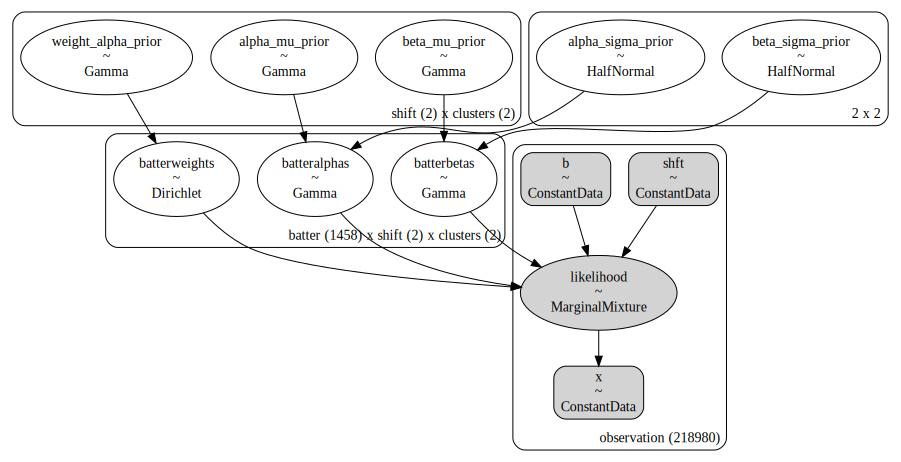

In [ ]:
graph = pm.model_to_graphviz(mod1)
graph

In [ ]:
with mod1:
    inference = pm.ADVI()
    approx = pm.fit(n=10000, method = inference)

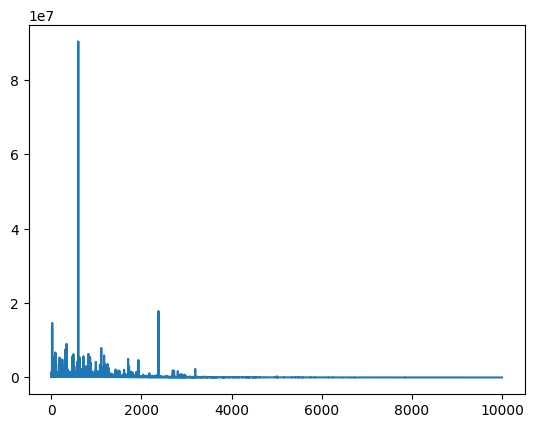

In [ ]:
plt.plot(inference.hist, label = 'advi')
plt.show()
trace = approx.sample(2000)

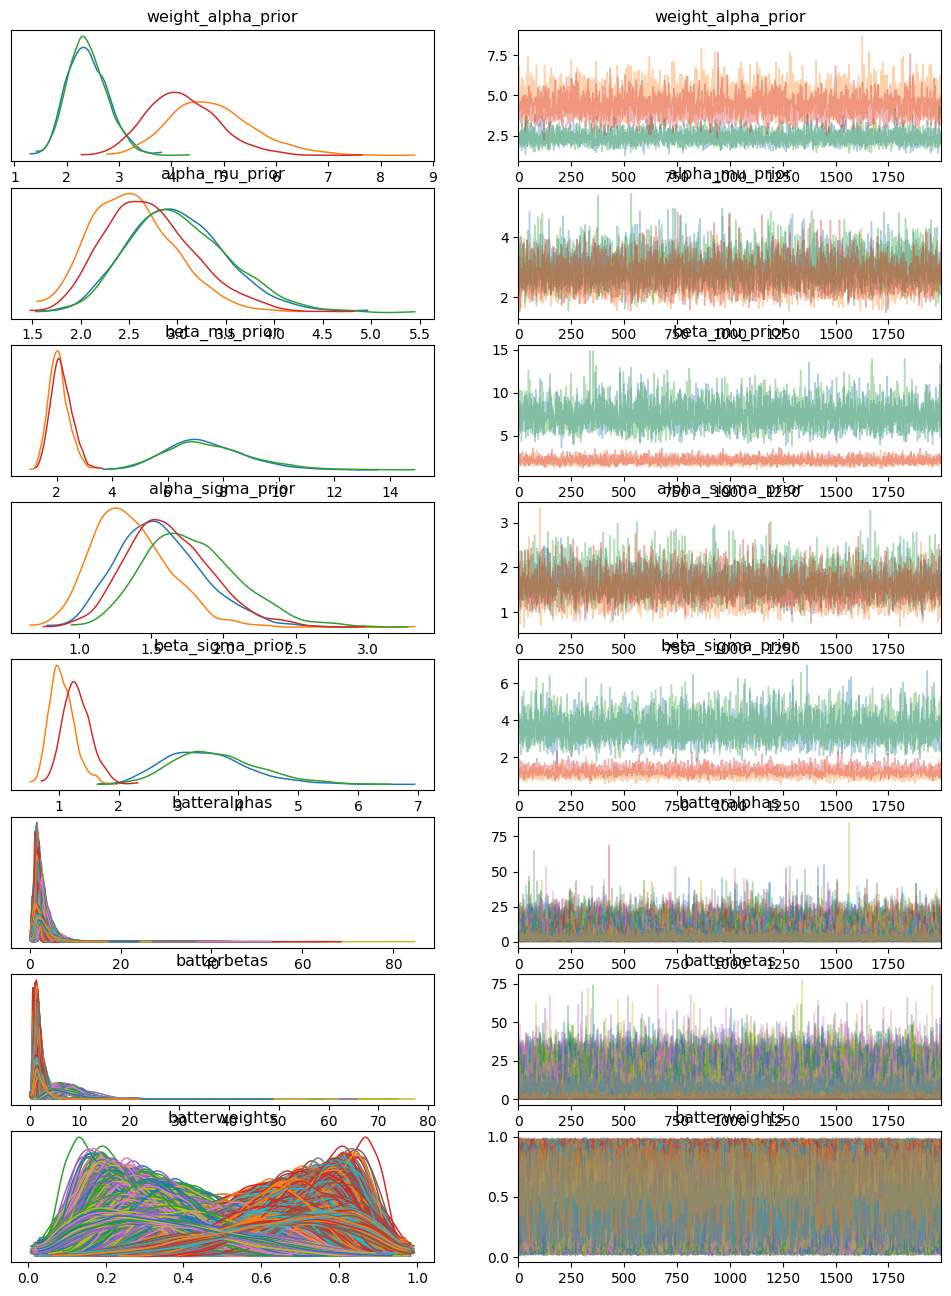

In [ ]:
az.plot_trace(trace)
plt.show()

In [ ]:
balphas = trace.posterior.batteralphas.sel(shift=0).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_alpha1', 'batter_alpha2']] = balphas
bbs = trace.posterior.batterbetas.sel(shift=0).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_beta1', 'batter_beta2']] = bbs
bweights = trace.posterior.batterweights.sel(shift=0).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_w1', 'batter_w2']] = bweights

sbalphas = trace.posterior.batteralphas.sel(shift=1).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_shift_alpha1', 'batter_shift_alpha2']] = sbalphas
sbbs = trace.posterior.batterbetas.sel(shift=1).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_shift_beta1', 'batter_shift_beta2']] = sbbs
sbweights = trace.posterior.batterweights.sel(shift=1).mean(dim = ('draw', 'chain')).to_numpy()
batter_indices[['batter_shift_w1', 'batter_shift_w2']] = sbweights

train = train.merge(batter_indices[['batter_index', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2', 'batter_shift_alpha1', 'batter_shift_alpha2', 'batter_shift_beta1', 'batter_shift_beta2', 'batter_shift_w1', 'batter_shift_w2']], on = 'batter_index')

In [ ]:
train['log_like'] = np.log((1-train.is_shift) * (train.batter_w1.values * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).pdf(train.hd.values) + train.batter_w2.values * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).pdf(train.hd.values)) + train.is_shift.values * (train.batter_shift_w1.values * beta(a = train.batter_shift_alpha1.values, b = train.batter_shift_beta1.values).pdf(train.hd.values) + train.batter_shift_w2.values * beta(a = train.batter_shift_alpha2.values, b = train.batter_shift_beta2.values).pdf(train.hd.values)))
train.log_like.mean()

0.1129040659489949

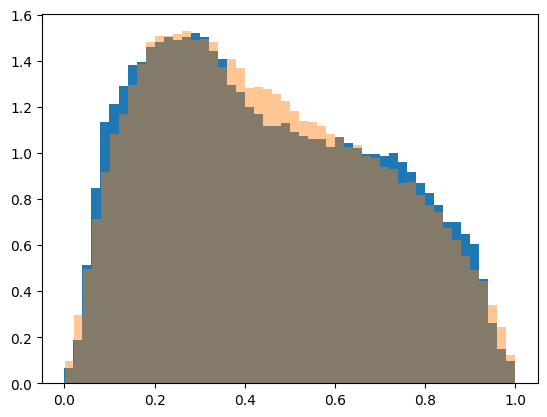

In [ ]:
#draw a sample for each hd in train
choice = np.random.binomial(1, train.batter_w1.values, size = train.shape[0])
samp = choice * beta(a = train.batter_alpha1.values, b = train.batter_beta1.values).rvs() + (1-choice) * beta(a = train.batter_alpha2.values, b = train.batter_beta2.values).rvs()
choice2 = np.random.binomial(1, train.batter_shift_w1.values, size = train.shape[0])
samp2 = choice2 * beta(a = train.batter_shift_alpha1.values, b = train.batter_shift_beta1.values).rvs() + (1-choice2) * beta(a = train.batter_shift_alpha2.values, b = train.batter_shift_beta2.values).rvs()
plt.hist(train.hd.values, density = True, bins = 50)
plt.hist(train.is_shift.values * samp2 + (1-train.is_shift.values)*samp, density = True, bins = 50, alpha = 0.45)
plt.show()

In [14]:
batter_indices = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/shift_beater_dists.csv')
train = train.merge(batter_indices[['batter_id_hand', 'batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2', 'batter_shift_alpha1', 'batter_shift_alpha2', 'batter_shift_beta1', 'batter_shift_beta2', 'batter_shift_w1', 'batter_shift_w2']], on = 'batter_id_hand')

In [15]:
train['shift_mean'] = train.batter_shift_w1.values * (train.batter_shift_alpha1.values / (train.batter_shift_alpha1.values + train.batter_shift_beta1.values)) + train.batter_shift_w2.values * (train.batter_shift_alpha2.values / (train.batter_shift_alpha2.values + train.batter_shift_beta2.values))
train['noshift_mean'] = train.batter_w1.values * (train.batter_alpha1.values / (train.batter_alpha1.values + train.batter_beta1.values)) + train.batter_w2.values * (train.batter_alpha2.values / (train.batter_alpha2.values + train.batter_beta2.values))

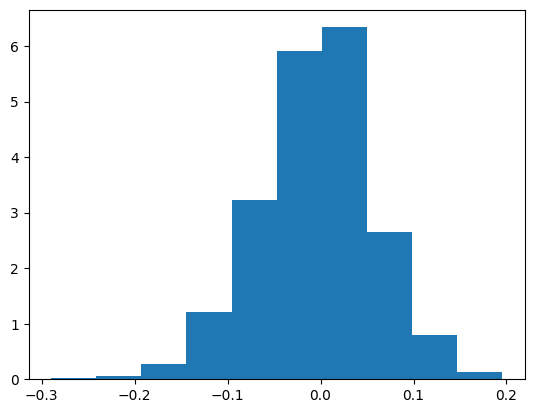

In [18]:
batter_indices['shift_mean'] = batter_indices.batter_shift_w1.values * (batter_indices.batter_shift_alpha1.values / (batter_indices.batter_shift_alpha1.values + batter_indices.batter_shift_beta1.values)) + batter_indices.batter_shift_w2.values * (batter_indices.batter_shift_alpha2.values / (batter_indices.batter_shift_alpha2.values + batter_indices.batter_shift_beta2.values))
batter_indices['noshift_mean'] = batter_indices.batter_w1.values * (batter_indices.batter_alpha1.values / (batter_indices.batter_alpha1.values + batter_indices.batter_beta1.values)) + batter_indices.batter_w2.values * (batter_indices.batter_alpha2.values / (batter_indices.batter_alpha2.values + batter_indices.batter_beta2.values))
batter_indices['mean_diff'] = batter_indices.shift_mean.values - batter_indices.noshift_mean.values
plt.hist(batter_indices.mean_diff.values, density = True)
plt.show()

In [16]:
shift_rates = train.groupby('batter_id_hand', as_index = False).agg(num_shifts = ('is_shift', 'sum'),
                                                                     N = ('is_shift', 'count'))
shift_rates['non_shifts'] = shift_rates.N.values - shift_rates.num_shifts.values
train = train.merge(shift_rates, on = 'batter_id_hand')

In [17]:
#identify hitters who go more oppo with the shift on
more_oppo = train.loc[train.noshift_mean < train.shift_mean]
#make sure they have a reasonable sample size of both shifts and non-shifts
more_oppo = more_oppo.loc[(more_oppo.num_shifts > 100) & (more_oppo.non_shifts > 100)]
#prioritize by biggest mean diff
more_oppo['mean_diff'] = more_oppo.shift_mean.values - more_oppo.noshift_mean.values
more_oppo.sort_values(by = 'mean_diff').batter_id_hand.unique()

array(['573131-1', '435559-1', '592885-0', '645277-1', '514888-1',
       '543807-1', '669242-0', '543760-1', '656669-1', '656775-0',
       '643217-0', '621493-1', '657557-1', '643393-0', '663697-1',
       '527038-1', '642715-1', '628450-0', '621020-1', '663757-0',
       '592450-1', '606992-1', '592273-1', '595777-0', '672695-0',
       '543333-0', '664023-0', '596748-1', '518692-0', '660821-0',
       '573262-0', '665862-0', '666158-0', '630105-0', '657077-0',
       '543939-0', '669257-1', '641857-0', '543068-1', '607043-0',
       '666185-0', '666969-1', '572041-1', '665120-0', '543063-0',
       '662139-0', '621438-1', '542303-1', '605141-1', '592325-0',
       '571745-1', '553993-1', '542364-0', '592178-1', '643446-0',
       '571771-1', '666915-1', '669720-1', '592206-1', '592192-1',
       '518626-1', '665742-0', '547180-0', '641531-1', '444482-0',
       '663586-1', '571976-1', '457705-1', '650402-1', '542583-1',
       '669016-0', '650859-0', '488726-0', '592200-1', '664774

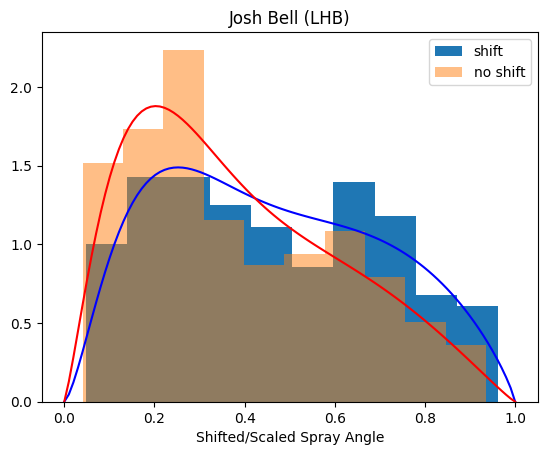

In [22]:
#Josh Bell (as a LHB)

brant = train.loc[train.batter_id_hand == '605137-0']
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
plt.hist(brants.hd.values, density = True, label = 'shift')
plt.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
plt.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
plt.title('Josh Bell (LHB)')
plt.xlabel('Shifted/Scaled Spray Angle')
plt.show()

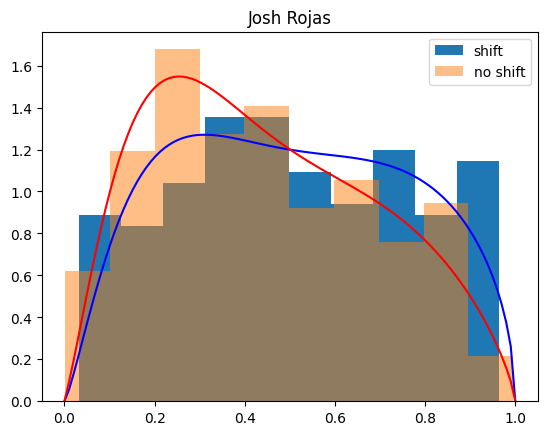

In [23]:
#Josh Rojas

brant = train.loc[train.batter == 668942]
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
plt.hist(brants.hd.values, density = True, label = 'shift')
plt.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
plt.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
plt.title('Josh Rojas')
plt.show()

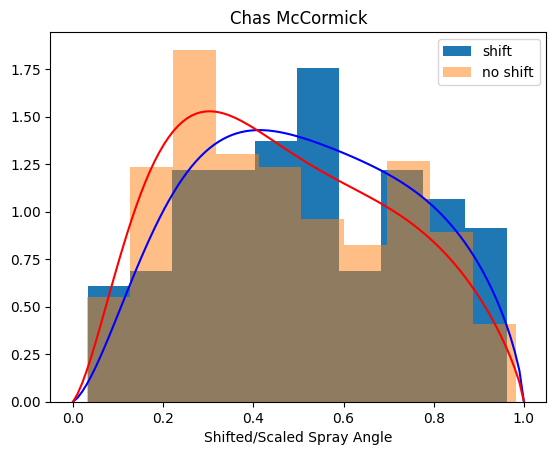

In [24]:
#Chas McCormick
brant = train.loc[train.batter == 676801]
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
plt.hist(brants.hd.values, density = True, label = 'shift')
plt.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
plt.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
plt.title('Chas McCormick')
plt.xlabel('Shifted/Scaled Spray Angle')
plt.show()

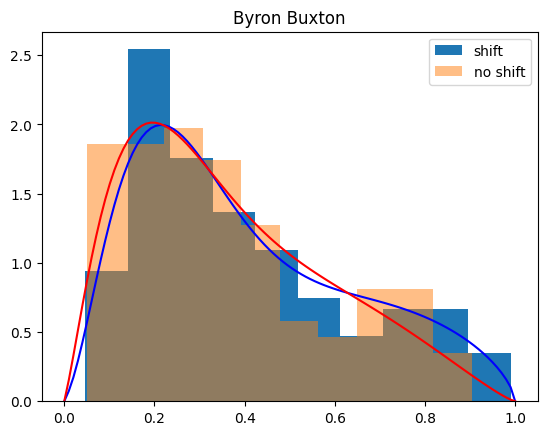

In [25]:
#byron buxton
brant = train.loc[train.batter == 621439]
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
plt.hist(brants.hd.values, density = True, label = 'shift')
plt.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
plt.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
plt.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
plt.title('Byron Buxton')
plt.show()

In [26]:
#I'd rather use a RHB since I used a LHB for the bunt equilibrium, so let's see if McCormick's distributions are significantly different using a KS test.
#draw a bunch of shift and nonshift samples for McCormick

brant = train.loc[train.batter == 676801]
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
choice1 = np.random.binomial(1, w1, size = 10000)
shift_samp = choice1 * beta(a = a1, b = b1).rvs(10000) + (1-choice1) * beta(a = a2, b = b2).rvs(10000)
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
choice2 = np.random.binomial(1, w1, size = 10000)
noshift_samp = choice2 * beta(a = a1, b = b1).rvs(10000) + (1-choice2) * beta(a = a2, b = b2).rvs(10000)

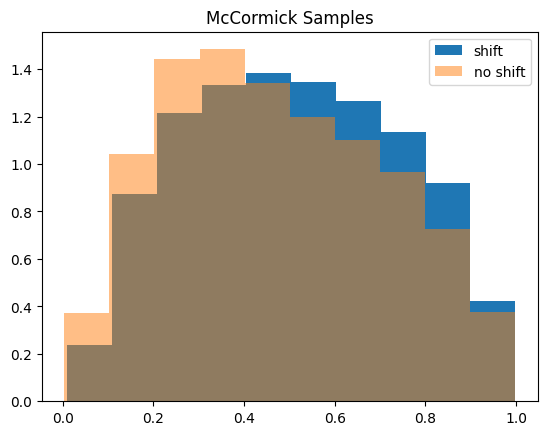

In [27]:
plt.hist(shift_samp, density = True, label = 'shift')
plt.hist(noshift_samp, density = True, label = 'no shift', alpha = 0.5)
plt.title('McCormick Samples')
plt.legend()
plt.show()

In [28]:
#ks test
from scipy.stats import kstest
kstest(shift_samp, noshift_samp)

KstestResult(statistic=0.0772, pvalue=2.473433498513938e-26, statistic_location=0.3880046592850665, statistic_sign=-1)

The p value in this 2-sided 2 sample KS test is 0, which means we reject the null hypothesis that the two distributions are the same. Thus, we conclude that McCormick's shift distribution is significantly different from his non-shift distribution.

In [ ]:
#save the posterior estimates
batter_indices.to_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/shift_beater_dists.csv', index=False)

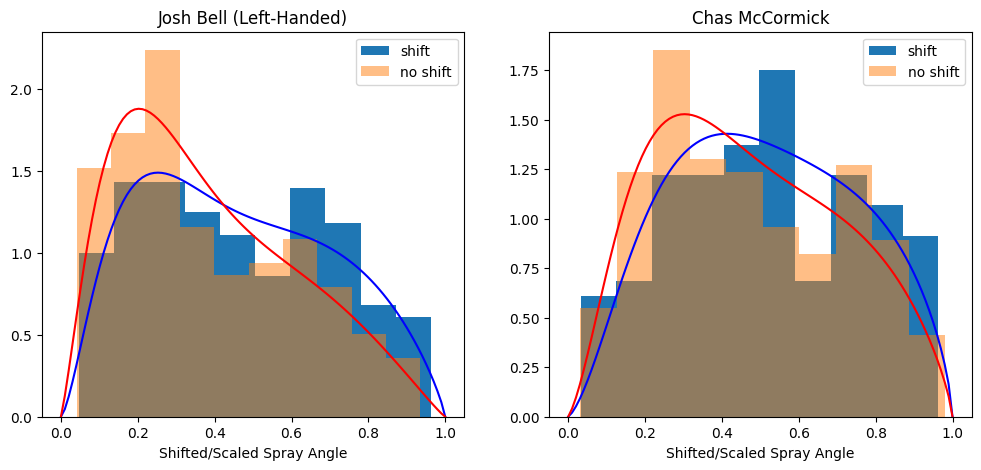

In [32]:
plt.figure(figsize = (12,5))
brant = train.loc[train.batter_id_hand == '605137-0']
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
ax1 = plt.subplot(121)
ax1.hist(brants.hd.values, density = True, label = 'shift')
ax1.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
ax1.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
ax1.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
ax1.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
ax1.set_title('Josh Bell (Left-Handed)')
ax1.set_xlabel('Shifted/Scaled Spray Angle')

brant = train.loc[train.batter == 676801]
brants = brant.loc[brant.is_shift == 1]
brantn = brant.loc[brant.is_shift == 0]
ax2 = plt.subplot(122)
ax2.hist(brants.hd.values, density = True, label = 'shift')
ax2.hist(brantn.hd.values, density = True, alpha = 0.5, label = 'no shift')
ax2.legend()
x = np.linspace(0,1,100)
w1 = brant.batter_shift_w1.values[0]
a1 = brant.batter_shift_alpha1.values[0]
b1 = brant.batter_shift_beta1.values[0]
w2 = brant.batter_shift_w2.values[0]
a2 = brant.batter_shift_alpha2.values[0]
b2 = brant.batter_shift_beta2.values[0]
ax2.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'b-')
w1 = brant.batter_w1.values[0]
a1 = brant.batter_alpha1.values[0]
b1 = brant.batter_beta1.values[0]
w2 = brant.batter_w2.values[0]
a2 = brant.batter_alpha2.values[0]
b2 = brant.batter_beta2.values[0]
ax2.plot(x, w1* beta(a = a1, b = b1).pdf(x) + w2 * beta(a = a2, b = b2).pdf(x), 'r-')
ax2.set_title('Chas McCormick')
ax2.set_xlabel('Shifted/Scaled Spray Angle')
plt.show()